In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
import scipy.stats as st
import arviz as az
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

D:\dev\playground\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

In [2]:
np.random.seed(0)
n_managers = 10
data = {}
data["m_0"] = st.norm(0.5, 2).rvs(5)
data["m_1"] = st.norm(-0.5, 2).rvs(10)
data["m_2"] = st.norm(0, 3).rvs(15)
data["m_3"] = st.norm(0, 1).rvs(20)
data["m_4"] = st.norm(0, 2).rvs(5)
data["m_5"] = st.norm(0, 2).rvs(5)
data["m_6"] = st.norm(0, 2).rvs(5)
data["m_7"] = st.norm(0, 2).rvs(5)
data["m_8"] = st.norm(-1, 3).rvs(5)
data["m_9"] = st.norm(0, 4).rvs(1)
data = dict([ (k,pd.Series(v)) for k,v in data.items() ])
data = pd.DataFrame(data)

In [3]:
data.mean()

m_0    3.400559
m_1    0.110745
m_2    0.596114
m_3   -0.312886
m_4   -0.891273
m_5   -0.079897
m_6   -1.357607
m_7   -0.969820
m_8   -0.301006
m_9   -2.739240
dtype: float64

## Define the independent model

In [4]:
def nonhierarchical_model(obs=None):
    μ_μ = 0
    α_τ = 1
    β_τ = 0.1
    with numpyro.plate("plate_i", n_managers):
        τ = numpyro.sample("τ", dist.Gamma(α_τ, β_τ))
        μ = numpyro.sample("μ", dist.Normal(μ_μ, 100))
        if obs is not None:
            numpyro.sample("obs", dist.Normal(μ, τ**-1).mask(~pd.isna(obs)), obs=obs)
        else:
            numpyro.sample("obs", dist.Normal(μ, τ**-1), obs=obs)

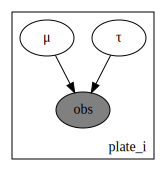

In [5]:
numpyro.render_model(nonhierarchical_model, model_args=(data.values, ))

In [6]:
nuts_kernel = NUTS(nonhierarchical_model)

mcmc_non = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc_non.run(rng_key, obs=data.values)

posterior_samples_non = mcmc_non.get_samples()

C:\Users\BearButis\AppData\Local\Temp\ipykernel_29972\2343750523.py:5: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  mcmc_non.run(rng_key, obs=data.values)
sample: 100%|█| 4000/4000 [00:06<00:00, 572.34it/s, 31 steps of size 1.27e-01. 


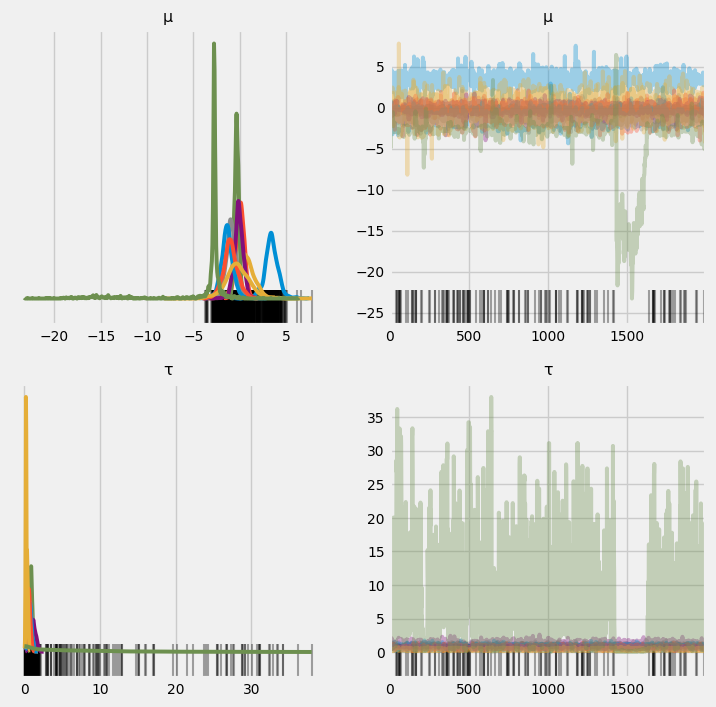

In [7]:
data_mcmc = az.from_numpyro(mcmc_non)
az.plot_trace(data_mcmc, compact=True, figsize=(8, 8));

## Define the hierarchical model

In [8]:
def hierarchical_model(obs=None):
    μ_μ = numpyro.sample("μ_α", dist.Normal(0.0, 100))
    α_τ = 1
    β_τ = 0.1
    τ_μ = numpyro.sample("τ_μ", dist.Gamma(α_τ, β_τ))
    with numpyro.plate("plate_i", n_managers): 
        τ = numpyro.sample("τ", dist.Gamma(α_τ, β_τ))
        μ = numpyro.sample("μ", dist.Normal(μ_μ, τ_μ**-1))
        if obs is not None:
            numpyro.sample("obs", dist.Normal(μ, τ**-1).mask(~pd.isna(obs)), obs=obs)
        else:
            numpyro.sample("obs", dist.Normal(μ, τ**-1), obs=obs)

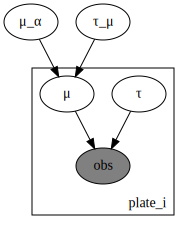

In [9]:
numpyro.render_model(hierarchical_model, model_args=(data.values, ))

In [10]:
nuts_kernel = NUTS(hierarchical_model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, obs=data.values)

posterior_samples = mcmc.get_samples()

C:\Users\BearButis\AppData\Local\Temp\ipykernel_29972\4047027937.py:5: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  mcmc.run(rng_key, obs=data.values)
sample: 100%|█| 4000/4000 [00:08<00:00, 487.83it/s, 63 steps of size 7.22e-02. 


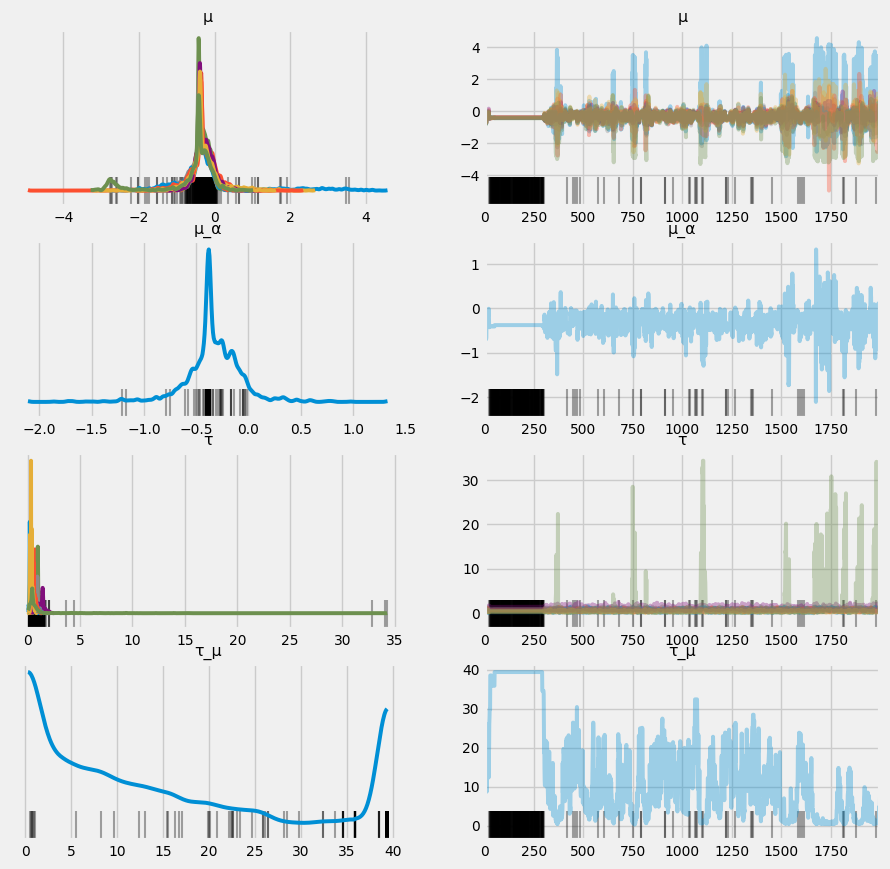

In [11]:
data_mcmc = az.from_numpyro(mcmc)
az.plot_trace(data_mcmc, compact=True, figsize=(10, 10));

## Predictive posteriors

In [12]:
predictive_non = Predictive(nonhierarchical_model, posterior_samples_non, return_sites=["obs", "μ"])
samples_predictive_non = predictive_non(random.PRNGKey(0), None)

In [13]:
predictive = Predictive(hierarchical_model, posterior_samples, return_sites=["obs", "μ"])
samples_predictive = predictive(random.PRNGKey(0), None)

## Raw data

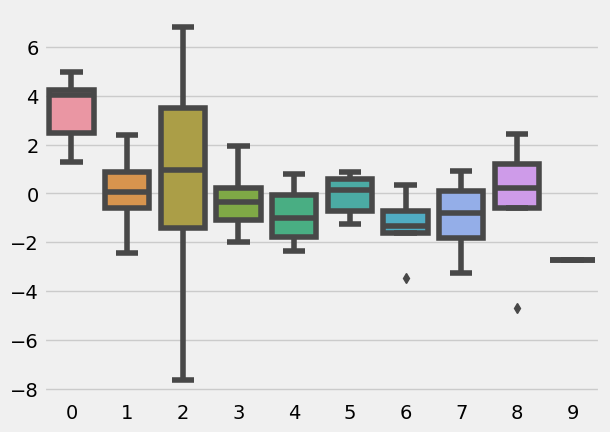

In [14]:
sns.boxplot(data.values);

## Posterior predictive

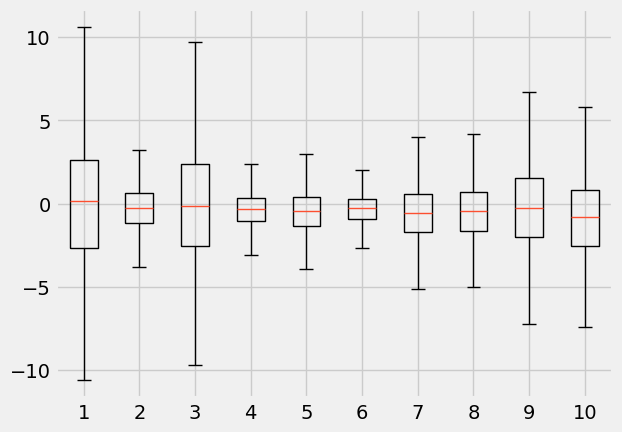

In [15]:
plt.boxplot(samples_predictive["obs"].T, showfliers=False);

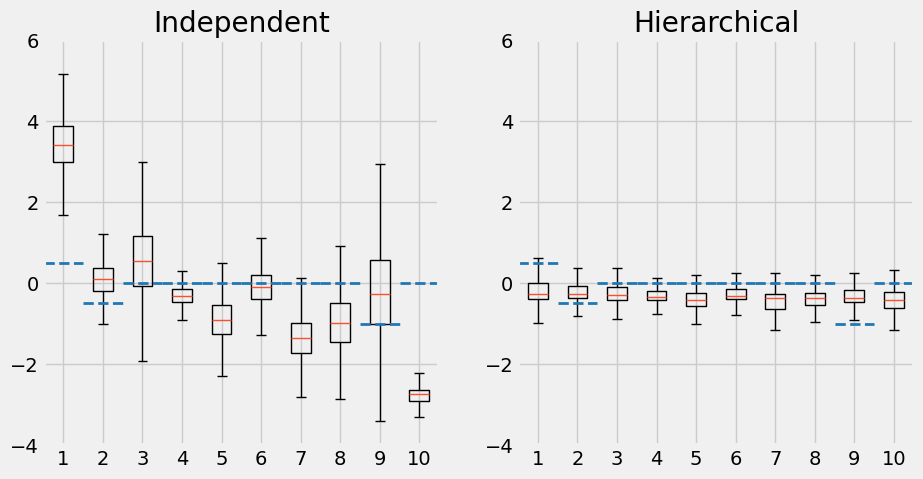

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.boxplot(samples_predictive_non["μ"].T, showfliers=False);
ax2.boxplot(samples_predictive["μ"].T, showfliers=False);
ax1.set_ylim(-4,6); ax1.set_title("Independent")
ax2.set_ylim(-4,6); ax2.set_title("Hierarchical")
ax1.axhline(0.5, 0, 0.1, lw=2, c="tab:blue", ls="--")
ax1.axhline(-0.5, 0.1, 0.2, lw=2, c="tab:blue", ls="--")
ax1.axhline(0, 0.2, 0.3, lw=2, c="tab:blue", ls="--")
ax1.axhline(0, 0.3, 0.4, lw=2, c="tab:blue", ls="--")
ax1.axhline(0, 0.4, 0.5, lw=2, c="tab:blue", ls="--")
ax1.axhline(0, 0.5, 0.6, lw=2, c="tab:blue", ls="--")
ax1.axhline(0, 0.6, 0.7, lw=2, c="tab:blue", ls="--")
ax1.axhline(0, 0.7, 0.8, lw=2, c="tab:blue", ls="--")
ax1.axhline(-1, 0.8, 0.9, lw=2, c="tab:blue", ls="--")
ax1.axhline(0, 0.9, 1, lw=2, c="tab:blue", ls="--")

ax2.axhline(0.5, 0, 0.1, lw=2, c="tab:blue", ls="--")
ax2.axhline(-0.5, 0.1, 0.2, lw=2, c="tab:blue", ls="--")
ax2.axhline(0, 0.2, 0.3, lw=2, c="tab:blue", ls="--")
ax2.axhline(0, 0.3, 0.4, lw=2, c="tab:blue", ls="--")
ax2.axhline(0, 0.4, 0.5, lw=2, c="tab:blue", ls="--")
ax2.axhline(0, 0.5, 0.6, lw=2, c="tab:blue", ls="--")
ax2.axhline(0, 0.6, 0.7, lw=2, c="tab:blue", ls="--")
ax2.axhline(0, 0.7, 0.8, lw=2, c="tab:blue", ls="--")
ax2.axhline(-1, 0.8, 0.9, lw=2, c="tab:blue", ls="--")
ax2.axhline(0, 0.9, 1, lw=2, c="tab:blue", ls="--");

In [17]:
data.mean()

m_0    3.400559
m_1    0.110745
m_2    0.596114
m_3   -0.312886
m_4   -0.891273
m_5   -0.079897
m_6   -1.357607
m_7   -0.969820
m_8   -0.301006
m_9   -2.739240
dtype: float64

## Truth

In [18]:
true_data = {}
true_data["m_1"] = st.norm(0.5, 2).rvs(1000)
true_data["m_2"] = st.norm(-0.5, 2).rvs(1000)
true_data["m_3"] = st.norm(0, 3).rvs(1000)
true_data["m_4"] = st.norm(0, 1).rvs(1000)
true_data["m_5"] = st.norm(0, 2).rvs(1000)
true_data["m_6"] = st.norm(0, 2).rvs(1000)
true_data["m_7"] = st.norm(0, 2).rvs(1000)
true_data["m_8"] = st.norm(0, 2).rvs(1000)
true_data["m_9"] = st.norm(-1, 3).rvs(1000)
true_data["m_10"] = st.norm(0, 4).rvs(1000)
true_data = dict([ (k,pd.Series(v)) for k,v in true_data.items() ])
true_data = pd.DataFrame(true_data)

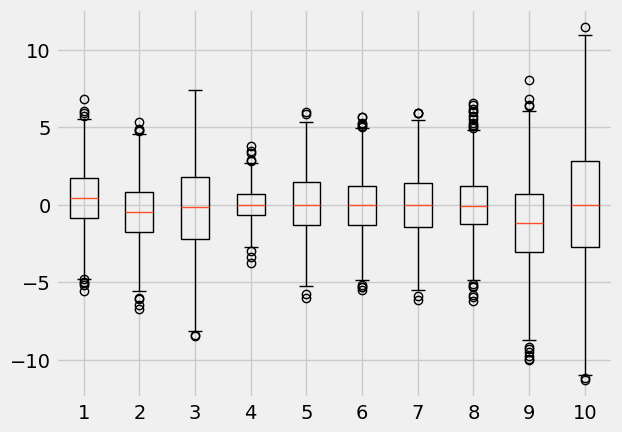

In [19]:
plt.boxplot(true_data.values);